In [1]:
import requests
from bs4 import BeautifulSoup as BSoup
import pandas as pd

In [2]:
import csv
import requests
import os
from datetime import datetime, timedelta
from abc import ABC, abstractmethod
import traceback

class SecFiling(ABC):
    """Holds the data of a generic SEC filing.
    
    Expected to be subclassed by 'SecFiling10K' and 'SecFiling10Q'. Also expected to be a utility to CanslimParams, i.e.
    driven by it.
    
    Before running this, make sure my edgar_idx.db is up-to-date. analyze_stockdata.get_list_sec_filings() will 
    update the 'idx' table (i.e. the database with the relevant urls), and analyze_stockdata.get_cik_ticker_lookup_db()
    will update the lookup table for CIK number - ticker symbol correlation.
    """
    def __init__(self, ticker):
        self.ticker = ticker
        self.xbrlInstance = None
        self.contextIds = {}
        self.currentContextId = ""
        self.errorLog = []
        self.currentSE = None
        self.currentNI = None
        self.reportDate = None
        
        
    def __del__(self):
        self.contextIds.clear()
        del self.errorLog[:]
        
    
    def getReportDate(self):
        return self.reportDate
        
        
    def download(self, cik, co_name, filing_type, filing_date, filing_link):
        """Retrieves a SEC filing from EDGAR. Follow by a call to 'load()'.
        
        Also a roundabout way of getting the filename for this data file.
        """
        # inspired by http://kaikaichen.com/?p=681
        saveas = '_'.join([cik, co_name, filing_type, str(filing_date)])
        saveDir = os.path.join("SECDATA", co_name)
        self.fname = os.path.join (saveDir, saveas)
        ## Only download if the file doesn't exist yet (at the expected path)
        if not os.path.exists(self.fname):
            url = 'https://www.sec.gov/Archives/' + filing_link.strip()
            if not os.path.exists(saveDir):
                os.makedirs(saveDir)
            with open("logfile.txt", "a+") as logfile:
                with open(self.fname, 'wb') as f:
                    f.write(requests.get('%s' % url).content)
                    logfile.write('{:s} - downloaded and saved as {:s}\n'.format(url, self.fname))
        return (self.fname)
    
    
    def load(self, fname):
        """Loads the data of SEC filing."""
        f = open (fname, "r")
        ## TODO: Do I need to have the whole file in memory?
        wholeFile = f.read ()
        f.close ()
        soup = BSoup (wholeFile, "lxml")
        ## Extract some basic info from the SEC-header section
        sec_header = soup.find("sec-header")
        try:
            for l in sec_header.text.split("\n"):
                if 'conformed period of report' in l.lower():
                    self.reportDate = datetime.strptime((l.split(":")[1]).strip(), "%Y%m%d")
                if 'standard industrial classification' in l.lower():
                    self.stdIndustrialClass = l.split(":")[1].strip()
            print("Report date: {:s}, industrial class: {:s}". format(str(self.reportDate), self.stdIndustrialClass))
        except:
            self.errorLog.append("Unable to find SEC-header in file.")
            return False
        
        ## Find the XBRL Instance document. It has the description-tag "XBRL INSTANCE DOCUMENT" within its document-tag.
        doc_tag = soup.find_all("document")
        try:
            for tag in doc_tag:
                description = tag.find("description").get_text().lower()
                if (description.startswith("xbrl instance document")):
                    self.xbrlInstance = tag
                    break
        except:
            self.errorLog.append("Unable to find document-tags in file.")
            return False
        
        if not self.xbrlInstance:
            self.errorLog.append("ERROR: unable to find Instance document for {:s}".format(self.fname))
            return False
        
        ## 'findAll('us-gaap:earningspersharebasic')' doesn't seem to work... so find them manually
        self.all_tags = self.xbrlInstance.findAll()
        if not self.all_tags:
            self.errorLog.append("No tags found!")
            return False
        return True
    
    
    def save(self):
        """Saves the data to file."""
        pass
     
        
    @abstractmethod
    def getEps(self):
        """Retrieve the current EPS from the filing."""
        ## 'findAll('us-gaap:earningspersharebasic')' doesn't seem to work... so find them manually
        pass
            
        
    @abstractmethod
    def getSales(self):
        """Retrieves the current Sales data from the filing.
        
        WARNING! The 'currentContextRef' member must have been set first (e.g. by calling getEps or getRoe 
        before calling this function) for this function to work properly. It seems to be very tricky to 
        figure out the currentContextRef by itself."""
        pass
        
        
    @abstractmethod
    def getRoe(self):
        """Retrieves the current Return on Equity from the filing."""
        pass
        
    @abstractmethod
    def getCurrentValue(self, tagList):
        pass
    
        
    def getStockholdersEquity(self):
        """Returns the value saved in self.currentSE.
        
        This attribute is populated by getRoe(). It is 'None' until that function is called. 
        Useful for debugging purposes. 
        """
        return self.currentSE
    
    
    def getNetIncome(self):
        """Returns the value saved in self.currentNI.
        
        This attribute is populated by getRoe(). It is 'None' until that function is called. 
        Useful for debugging purposes. 
        """
        return self.currentNI
            
    def getStartEndDateForContext(self, contextRef):
        """Looks up the date for the given contextref/id.

        This used to be a method under the SecFiling class. For some reason (me, Jupyter notebooks, other), 
        I would get an AttributeError that SecFiling10Q did not have this attribute when calling, e.g. 'getEps()
        on a SecFiling10Q object. So I nested it here under 'getCurrentValue'. """
        periodXml = self.xbrlInstance.find("xbrli:context", {"id" : contextRef})
        if periodXml:
            startdate = periodXml.find("xbrli:startdate") ## or just 'startdate'
            enddate = periodXml.find("xbrli:enddate") ## or just 'enddate'
            if not startdate and not enddate:
                startdate = periodXml.find("xbrli:instant") ## instantaneous date, not a date range
                enddate = startdate
        else:
            print("ERROR: Unable to find dates for contextref '{:s}'".format(contextRef))
            return None
        try:
            sd = datetime.strptime(startdate.text, "%Y-%m-%d")
        except:
            sd = None
        try:
            ed = datetime.strptime(enddate.text, "%Y-%m-%d")
        except:
            ed = None
        return [sd, ed]
        
        
    def printErrors(self):
        print("\n".join(e for e in self.errorLog))
            


In [3]:
class SecFiling10Q(SecFiling):
        
    def getEps(self):
        """Retrieve the current EPS from the filing."""
        all_eps_tags = []
        try:
            for tag in self.all_tags:
                if 'us-gaap:earningspersharebasic' in tag.name:
                    all_eps_tags.append(tag)
            self.currentEps = self.getCurrentValue(all_eps_tags)
        except:
            self.errorLog.append("Unable to find the EPS information in the filing.")
            return None
        return self.currentEps
                    
    
    def getSales(self):
        """Retrieves the current Sales data from the filing.
        
        WARNING! The 'currentContextRef' member must have been set first (e.g. by calling getEps or getRoe 
        before calling this function) for this function to work properly. It seems to be very tricky to 
        figure out the currentContextRef by itself."""
        if not self.currentContextId:
            print("ERROR! current contextId is not set!")
            return -99.0
        all_sales_tags = []
        try:
            for tag in self.all_tags:
                ## The filings seem to use either 'Revenues' or 'SalesRevenuesNet' to indicate the net sales amount
                ## But the 'Revenues' tag also contains other stuff, need to filter it by its contextref attribute
                if 'us-gaap:Revenues'.lower() == tag.name.strip():
                    if (tag.attrs)['contextref'] == self.currentContextId:
                        all_sales_tags.append(tag)
                elif 'us-gaap:SalesRevenuesNet'.lower() == tag.name.strip():
                    all_sales_tag.append(tag)
        except:
            self.errorLog.append("Unable to find Sales data in filing.")
            return None
        self.currentSales = self.getCurrentValue(all_sales_tags) 
        return self.currentSales
    
    
    def getRoe(self):
        """Retrieves the current Return on Equity from the filing."""
        ## First find the stockholders' equity
        all_se_tags = []
        ## Then find the net income
        all_ni_tags = []
        self.currentSE = None
        self.currentNI = None
        try:
            for tag in self.all_tags:
                if 'us-gaap:StockholdersEquity'.lower() == tag.name.strip():
                    all_se_tags.append(tag)
                if 'us-gaap:NetIncomeLoss'.lower() == tag.name.strip():
                    all_ni_tags.append(tag)
            self.currentSE = self.getCurrentValue(all_se_tags)
            self.currentNI = self.getCurrentValue(all_ni_tags)
            print("SE: ", self.currentSE, ", NI: ", self.currentNI)
        except:
            if not self.currentSE:
                self.errorLog.append("Unable to find Stockholders' Equity in filing.")
            if not self.currentNI:
                self.errorLog.append("Unable to find Net Income in filing.")
            return None
        ## Return on equity = net income / stockholders' equity
        self.currentRoe = 0.0
        if self.currentSE > 0.0:
            self.currentRoe = self.currentNI / self.currentSE
        return self.currentRoe
      
    
    def getCurrentValue(self, tagList):
        """Finds the tag for the current date from a list of tags, and returns its value."""
        prevDiff = timedelta(9999, 0, 0) ## days, seconds, microseconds (!)
        prevContextRefLen = 100000
        try:
            for tag in tagList:
                ## Find the quarter that ended closest to the reportDate, make sure it's a quarter
                ## TODO: figure out how to do this for the 10-K's
                contextRef = str((tag.attrs)['contextref'])
                ## The various 'us-gaap:<quantity-of-interest>' tags can occur multiple times for the same time frame,
                ## but usually distinguish between contextRef names (i.e. the contextref attributes are different, but 
                ## denote the same time frame). It seems that I generally want the contextRef with the shortest name
                ## (i.e. least special one)?
                contextRefLen = len(contextRef)
                if contextRef in self.contextIds:
                    tag_dates = self.contextIds[contextRef]
                else:
                    tag_dates = self.getStartEndDateForContext(contextRef)
                    self.contextIds[contextRef] = tag_dates
                diff = self.reportDate - tag_dates[1]
                ## Find the closest enddate to the ReportDate, i.e. the 'current' date
                if abs(diff.days) < abs(prevDiff.days): ## found a date closer to the reportDate
                    prevDiff = diff
                    ## Reset the length of the contextref string
                    prevContextRefLen = 100000
                ## found another candidate, do all the checks
                if abs(diff.days) <= abs(prevDiff.days): ## found a date closer to the reportDate 
                    ## If the date is an instantaneous date, only look at the 'diff'
                    if tag_dates[1] == tag_dates[0]:
                        if contextRefLen < prevContextRefLen:
                            prevContextRefLen = contextRefLen
                            current = tag
                            prevDiff = diff
                    ## If a date range is given, make sure it's about a year long
                    elif abs((tag_dates[1] - tag_dates[0]).days - 90) < 5:
                        if contextRefLen < prevContextRefLen:
                            prevContextRefLen = contextRefLen
                            current = tag
                            prevDiff = diff
            self.currentContextId = (current.attrs)['contextref']
        except Exception as ex:
            self.errorLog.append("Unable to determine the current value:")
            self.errorLog.append(type(ex).__name__)
            self.errorLog.append(ex)
            traceback.print_exc()
            return None
        return float(current.text)  
    
    def printErrors(self):
        super()




In [4]:
class SecFiling10K(SecFiling):
    def getEps(self):
        """Retrieve the current EPS from the filing."""
        all_eps_tags = []
        try:
            for tag in self.all_tags:
                if 'us-gaap:earningspersharebasic' in tag.name:
                    all_eps_tags.append(tag)
            self.currentEps = self.getCurrentValue(all_eps_tags)
        except:
            self.errorLog.append("Unable to find the EPS information in the filing.")
            return None
        return self.currentEps
                    
    
    def getSales(self):
        """Retrieves the current Sales data from the filing.
        
        WARNING! The 'currentContextRef' member must have been set first (e.g. by calling getEps or getRoe 
        before calling this function) for this function to work properly. It seems to be very tricky to 
        figure out the currentContextRef by itself."""
        if not self.currentContextId:
            print("ERROR! current contextId is not set!")
            return -99.0
        all_sales_tags = []
        try:
            for tag in self.all_tags:
                ## The filings seem to use either 'Revenues' or 'SalesRevenuesNet' to indicate the net sales amount
                ## But the 'Revenues' tag also contains other stuff, need to filter it by its contextref attribute
                if 'us-gaap:Revenues'.lower() == tag.name.strip():
                    if (tag.attrs)['contextref'] == self.currentContextId:
                        all_sales_tags.append(tag)
                elif 'us-gaap:SalesRevenuesNet'.lower() == tag.name.strip():
                    all_sales_tag.append(tag)
        except:
            self.errorLog.append("Unable to find Sales data in filing.")
            return None
        self.currentSales = self.getCurrentValue(all_sales_tags) 
        return self.currentSales
    
    
    def getRoe(self):
        """Retrieves the current Return on Equity from the filing."""
        ## First find the stockholders' equity
        all_se_tags = []
        ## Then find the net income
        all_ni_tags = []
        self.currentSE = None
        self.currentNI = None
        try:
            for tag in self.all_tags:
                if 'us-gaap:StockholdersEquity'.lower() == tag.name.strip():
                    all_se_tags.append(tag)
                if 'us-gaap:NetIncomeLoss'.lower() == tag.name.strip():
                    all_ni_tags.append(tag)
            self.currentSE = self.getCurrentValue(all_se_tags)
            self.currentNI = self.getCurrentValue(all_ni_tags)
            print("SE: ", self.currentSE, ", NI: ", self.currentNI)
        except:
            if not self.currentSE:
                self.errorLog.append("Unable to find Stockholders' Equity in filing.")
            if not self.currentNI:
                self.errorLog.append("Unable to find Net Income in filing.")
            return None
        ## Return on equity = net income / stockholders' equity
        self.currentRoe = 0.0
        if self.currentSE > 0.0:
            self.currentRoe = self.currentNI / self.currentSE
        return self.currentRoe


        
    def getCurrentValue(self, tagList):
        """Finds the tag for the current date from a list of tags, and returns its value."""
        prevDiff = timedelta(9999, 0, 0) ## days, seconds, microseconds (!)
        prevContextRefLen = 100000
        try:
            for tag in tagList:
                ## Find the quarter that ended closest to the reportDate, make sure it's a quarter
                ## TODO: figure out how to do this for the 10-K's
                contextRef = str((tag.attrs)['contextref'])
                ## The various 'us-gaap:<quantity-of-interest>' tags can occur multiple times for the same time frame,
                ## but usually distinguish between contextRef names (i.e. the contextref attributes are different, but 
                ## denote the same time frame). It seems that I generally want the contextRef with the shortest name
                ## (i.e. least special one)?
                contextRefLen = len(contextRef)
                if contextRef in self.contextIds:
                    tag_dates = self.contextIds[contextRef]
                else:
                    tag_dates = self.getStartEndDateForContext(contextRef)
                    self.contextIds[contextRef] = tag_dates
                diff = self.reportDate - tag_dates[1]
                ## Find the closest enddate to the ReportDate, i.e. the 'current' date
                if abs(diff.days) < abs(prevDiff.days): ## found a date closer to the reportDate
                    prevDiff = diff
                    ## Reset the length of the contextref string
                    prevContextRefLen = 100000
                ## found another candidate, do all the checks
                if abs(diff.days) <= abs(prevDiff.days): ## found a date closer to the reportDate 
                    ## If the date is an instantaneous date, only look at the 'diff'
                    if tag_dates[1] == tag_dates[0]:
                        if contextRefLen < prevContextRefLen:
                            prevContextRefLen = contextRefLen
                            current = tag
                            prevDiff = diff
                    ## If a date range is given, make sure it's about a year long
                    elif abs((tag_dates[1] - tag_dates[0]).days - 365) < 10:
                        if contextRefLen < prevContextRefLen:
                            prevContextRefLen = contextRefLen
                            current = tag
                            prevDiff = diff
            self.currentContextId = (current.attrs)['contextref']
        except Exception as ex:
            self.errorLog.append("Unable to determine the current value:")
            self.errorLog.append(type(ex).__name__)
            self.errorLog.append(ex)
            traceback.print_exc()
            return None
        return float(current.text)  



In [26]:
import unittest

class TestNotebook(unittest.TestCase):

    def test_add(self):
        self.assertEqual(add(2, 2), 5)
        
    ## NVDA 10Q
    ## NVDA 10K
    ## AAPL 10Q
    ## AAPL 10K


unittest.main(argv=[''], verbosity=2, exit=False)

test_add (__main__.TestNotebook) ... ERROR

ERROR: test_add (__main__.TestNotebook)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<ipython-input-26-2e409d30af6a>", line 6, in test_add
    self.assertEqual(add(2, 2), 5)
NameError: name 'add' is not defined

----------------------------------------------------------------------
Ran 1 test in 0.007s

FAILED (errors=1)


In [5]:
from numpy import polyfit

class CanslimParams():
    def __init__(self, ticker, all10QsDf, all10KsDf):
        self.ticker = ticker
        ## Format the 'date' column into datetime format
        self.all10QsDf = all10QsDf
        self.all10KsDf = all10KsDf
        self.today = datetime.now()
        self.fiveYearsAgo = self.today - timedelta(days=5*365.25)
        self.currentQ = ""
        self.currentY = ""
        self.quartersList = []
        self.yearsList = []
        self.all10QFilings = {}
        self.all10KFilings = {}

        
    def loadData(self):
        """Loads the relevant SEC filings for analysis.
        
        Loads the last 4 10-K filings and the last 16(?) 10-Q filings. If necessary, 
        retrieves them from EDGAR and saves the raw files.
        """
        ## TODO: Look through the idx database and find all filings available for 'ticker'. -> in main()
        self.all10QFilings = {}
        self.all10KFilings = {}
        n10Qs = len(self.all10QsDf)
        n10Ks = len(self.all10KsDf)
        ## The following loops lend themselves to parallelizing, if that's possible
        ## Create a dict of all the 10Q-filings objects
        mostRecentDate = self.fiveYearsAgo
        for i in range(0, n10Qs):
            if (self.all10QsDf.iloc[i].date > self.fiveYearsAgo):
                filing = SecFiling10Q(self.ticker)
                ## Download file if necessary, and generate the file name
                fname = filing.download(self.all10QsDf.iloc[i].cik, \
                                        self.all10QsDf.iloc[i].conm, \
                                        self.all10QsDf.iloc[i].type, \
                                        self.all10QsDf.iloc[i].date.strftime("%Y-%m-%f"), \
                                        self.all10QsDf.iloc[i].path)
                ## Load the file into the object instance
                filing.load(fname)
                ## Use the year+quarter (for filing date) information to create a key into the dict
                quarterKey = "{:d}-Q{:d}".format(self.all10QsDf.iloc[i].date.year, int(self.all10QsDf.iloc[i].date.month / 3 + 1))
                print(quarterKey)
                ## TODO: verify that each filing was successfully loaded
                self.all10QFilings[quarterKey] = filing
                ## find the date of the most recent filing, to determine the "current quarter"
                if self.all10QsDf.iloc[i].date > mostRecentDate:
                    mostRecentDate = self.all10QsDf.iloc[i].date
                    self.currentQ = quarterKey
                    
        # Create a dict of all the 10K-filing objects:
        mostRecentDate = self.fiveYearsAgo
        for i in range(0, n10Ks):
            if (self.all10KsDf.iloc[i].date > self.fiveYearsAgo):
                filing = SecFiling10K(self.ticker)
                ## Download file if necessary, and generate the file name
                fname = filing.download(self.all10KsDf.iloc[i].cik, \
                                        self.all10KsDf.iloc[i].conm, \
                                        self.all10KsDf.iloc[i].type, \
                                        self.all10KsDf.iloc[i].date.strftime("%Y-%m-%f"), \
                                        self.all10KsDf.iloc[i].path)
                ## Load the file into the object instance
                filing.load(fname)
                ## Use the year+quarter (for filing date) information to create a key into the dict
                yearKey = "Y{:d}".format(self.all10KsDf.iloc[i].date.year)
                print(yearKey)
                ## TODO: verify that each filing was successfully loaded
                self.all10KFilings[yearKey] = filing
                ## find the date of the most recent filing, to determine the "current year"
                if self.all10KsDf.iloc[i].date > mostRecentDate:
                    mostRecentDate = self.all10KsDf.iloc[i].date
                    self.currentY = yearKey
        return True
    
                
    def _getQuarter(self, q):
        """Returns the quarter-key for the requested quarter in the past.
        
        The format of the quarter-key is 'Ynnnn-Qm' and is intended to be used to index into the all10QFilings-dict of 
        SecFiling10Q instances.
        """
        if abs(q) > 20:
            return None
        if not self.quartersList:
            currentYear = int(self.currentQ.split("-Q")[0])
            currentQuarter = int(self.currentQ.split("-Q")[1])
            self.quartersList.append(self.currentQ)
            quarter = currentQuarter
            year = currentYear
            for i in range(0,20):
                quarter = quarter - 1
                if quarter < 1:
                    quarter = quarter + 4
                    year = year - 1
                self.quartersList.append("{:d}-Q{:d}".format(year, quarter))
            print(self.quartersList)
        return self.quartersList[abs(q)]
    
    
    def _getYear(self, y):
        """Returns the year-key for the requested year in the past.
        
        The format of the year-key is 'Ynnnn' and is intended to be used to index into the all10KFilings-dict of 
        SecFiling10K instances.
        """
        if abs(y) > 5:
            return None
        if not self.yearsList:
            currentYear = int(self.currentY[1:])
            for i in range(0,5):
                year = currentYear - i
                self.yearsList.append("Y{:d}".format(year))
            print(self.yearsList)
        return self.yearsList[abs(y)]
    
    
    def getEpsQuarter(self, quarter):
        """Returns the EPS for the specified quarter.
        
        The quarter is specified as an integer counting backwards, e.g. 0 (zero) is the current quarter,
        -1 (minus one) is the previous quarter, etc. For readability, the minus sign is required. Only 
        integers between -15 and 0 are allowed.
        """
        if quarter > -20:
            qKey = self._getQuarter(quarter)
            print("qKey= ", qKey)
            return (self.all10QFilings)[qKey].getEps()
        return None
    
    
    def getEpsAnnual(self, year):
        """Returns the EPS for the specified year.
        
        The year is specified as an integer counting backwards, e.g. 0 (zero) is the most recent reported year,
        -1 (minus one) is the previous year, etc. For readability, the minus sign is required. Only 
        integers between -3 and 0 are allowed.
        """
        if year > -5:
            yKey = self._getYear(year)
            print("yKey= ", yKey)
            return self.all10KFilings[yKey].getEps()
        return None
    
    
    def getRoeCurrent(self):
        """Returns the most recent Return on Equity."""
        return self.all10QFilings[self.currentQ].getRoe()
    
    
    def getSalesQuarter(self, quarter):
        """Returns the Sales for the specified quarter.
        
        The quarter is specified as an integer counting backwards, e.g. 0 (zero) is the current quarter,
        -1 (minus one) is the previous quarter, etc. For readability, the minus sign is required. Only 
        integers between -15 and 0 are allowed.
        """
        if quarter > -20:
            qKey = self._getQuarter(quarter)
            print("qKey= ", qKey)
            return self.all10Qfilings[qKey].getSales()
        return None
    
    
    def getSalesAnnual(self, year):
        """Returns the Sales for the specified year.
        
        The year is specified as an integer counting backwards, e.g. 0 (zero) is the most recent reported year,
        -1 (minus one) is the previous year, etc. For readability, the minus sign is required. Only 
        integers between -3 and 0 are allowed.
        """
        if year > -5:
            yKey = self._getYear(year)
            print("yKey= ", yKey)
            return self.all10KFilings[yKey].getSales()
        return None
    
        
    def getEpsGrowthQuarter(self, q1, q2):
        """Calculates the EPS growth (%) for quarter q1 compared to q2.
        
        The EPS growth is calculated as the ratio EPS(q1)/EPS(q2) * 100%.
        """
        q1Key = self._getQuarter(q1)
        epsQ1 = self.all10QFilings[q1Key].getEps()
        q2Key = self._getQuarter(q2)
        epsQ2 = self.all10QFilings[q2Key].getEps()
        try:
            print("EPS1= ", epsQ1, " Eps2= ", epsQ2)
            growth = (epsQ1 / epsQ2) * 100.
        except:
            print("Unable to determine quarterly EPS growth.")
            growth = None
        return growth
    
    
    def getEpsGrowthAnnual(self, a1, a2):
        """Calculates the EPS growth (%) for year a1 compared to a2.
        
        The EPS growth is calculated as the ratio EPS(a1)/EPS(a2) * 100%.
        """
        y1Key = self._getYear(a1)
        epsY1 = self.all10KFilings[y1Key].getEps()
        y2Key = self._getYear(a2)
        epsY2 = self.all10KFilings[y2Key].getEps()
        try:
            print("EPS1= ", epsY1, " Eps2= ", epsY2)
            growth = (epsY1 / epsY2) * 100.
        except:
            print("Unable to determine quarterly EPS growth.")
            growth = None
        return growth
        
        
    def __slope(self, xf, xi, yf, yi):
        """Calculates the slope as (yf-yi)/(xf-xi)."""
        if (xf - xi) == 0.0:
            return 0.0

        return float((yf - yi) / (xf - xi))
    
    
    def getStabilityOfEpsGrowth(self, numQuarters):
        """Calculates the stability of the quarterly EPS growth over the last numQuarters (<20).
        
        The stability is calculated as the amount of deviation from the best-fit-line growth. 
        In other words, a line is fitted through the data, and the goodness-of-fit is determined.
        """
        if numQuarters < 20:
            x = []
            y = []
            firstDate = self.all10QFilings[self._getQuarter(0)].getReportDate()
            ## create the arrays of EPS vs nDays (from most recent filing) values
            for i in range(0, -numQuarters, -1):
                qKey = self._getQuarter(i)
                y.append(self.all10QFilings[qKey].getEps())
                x.append((firstDate - self.all10QFilings[qKey].getReportDate()).days)
            print("Arrays:\n", x, y)
            ## Fit a polynomial of degree 1 through the data: bx + c. Then compute the goodness-of-fit.
            p = polyfit(x, y, 1)
            yfit = polyval(p, x)
            print("yfit: ", yfit)
            sigma = (y - yfit) / y
            print("sigma= ", sigma)
            error = sigma * sigma
            res = error.sum()
            return res
        return None
    
    
    def getEpsGrowthAcceleration(self, numQuarters):
        """Returns the (mean) acceleration of EPS growth over the specified number of quarters.
        
        The acceleration is calculated as the second derivative of the data. numQuarters is required to 
        be between 2 and 15. At least three quarters are necessary to calculate acceleration.
        """
        if numQuarters < 20:
            x = []
            y = []
            firstDate = self.all10QFilings[self._getQuarter(0)].getReportDate()
            ## create the arrays of EPS vs nDays (from most recent filing) values
            for i in range(0, -numQuarters, -1):
                qKey = self._getQuarter(i)
                y.append(self.all10QFilings[qKey].getEps())
                x.append((firstDate - self.all10QFilings[qKey].getReportDate()).days)
            print("Arrays:\n", x, y)
            ## Fit a polynomial of degree 2 through the data: ax**2 + bx + c. 'a' should be the acceleration
            p = polyfit(x, y, 2)
            return p[0]
        return None
    
    
    def getSalesGrowth(self, q1, q2):
        """Calculates the Sales growth (%) for quarter q1 compared to q2.
        
        The Sales growth is calculated as the ratio Sales(q1)/Sales(q2) * 100%.
        """
        q1Key = self._getQuarter(q1)
        salesQ1 = self.all10QFilings[q1Key].getSales()
        q2Key = self._getQuarter(q2)
        salesQ2 = self.all10QFilings[q2Key].getSales()
        try:
            growth = (salesQ1 / salesQ2) * 100.
        except:
            print("Unable to determine quarterly Sales growth.")
            growth = None
        return growth
    
    
    def getSalesGrowthAcceleration(self, numQuarters):
        """Returns the (mean) acceleration of Sales growth over the specified number of quarters.
        
        The acceleration is calculated as the second derivative of the data. numQuarters is required to 
        be between 2 and 15. At least three quarters are necessary to calculate acceleration.
        """
        if numQuarters < 20:
            x = []
            y = []
            firstDate = self.all10QFilings[self._getQuarter(0)].getReportDate()
            ## create the arrays of EPS vs nDays (from most recent filing) values
            for i in range(0, -numQuarters, -1):
                qKey = self._getQuarter(i)
                y.append(self.all10QFilings[qKey].getSales())
                x.append((firstDate - self.all10QFilings[qKey].getReportDate()).days)
            print("Arrays:\n", x, y)
            ## Fit a polynomial of degree 2 through the data: ax**2 + bx + c. 'a' should be the acceleration
            p = polyfit(x, y, 2)
            return p[0]
        return None
    
    
    def plotEpsQuarter(self):
        """Generates a log-plot of quarterly EPS data."""
        pass
    
    def plotStockData(self):
        """Generates a plot of the weekly stock data for the last three years."""
        pass
    
    def getStockData(self):
        """Download the weekly stock data for the last three years from somehwere."""
        pass
    
    def getStockGrowth(self):
        """Returns the stock growth as the slope of the best-fit line through the stock data."""
        pass
    
    def getStockAcceleration(self):
        """Fits the equation a*x^2+b*x+c through the data and returns the 'a' coefficient."""
        pass
    
    ## Lofty future goal: write algorithm(s) that identifies Canslim patterns in the stock data
        

In [9]:
class ATest(self):
    self.d = {}
    
    def getValFromDict(self, n):
        if not self.d:
            for i in range(0,20):
                self.d["Val-{:d}".format(i)]= i
        print(self.d)

NameError: name 'self' is not defined

In [11]:
import pandas as pd
from sqlalchemy import create_engine

symbol = "AAPL"

engine = create_engine('sqlite:///edgar_idx.db')
with engine.connect() as conn, conn.begin():
    #load the table with the index files info
    idx = pd.read_sql_table('idx', conn, parse_dates=['date'])
    #load the look-up table for ticker symbol to CIK translation
    cik_ticker_name = pd.read_sql_table ('cik_ticker_name', conn)
    ## Get the 10-K and 10-Q filing references from the database
    #handle the case where there are multiple stocks with the same ticker; just select the first?!?
    cik =((cik_ticker_name.cik[cik_ticker_name.ticker == symbol]))
    #print (type(cik.iloc[0]))
    all_links = idx[idx.cik == cik.iloc[0]]
    all_10Qs = all_links[all_links.type == '10-Q']
    #verify that this gets the amended 10-Q's
    #all_filings.append (all_links[all_links.type == '10-Q\A'])
    all_10Ks = all_links[all_links.type == '10-K']

In [12]:
all_10Qs.to_csv("TestData\\appl_all_10qs.csv", index=None)
all_10Ks.to_csv("TestData\\appl_all_10ks.csv", index=None)

In [13]:
all_10Ks =pd.read_csv("TestData\\nvda_all_10ks.csv", parse_dates=['date'], dtype={'cik':str, 'conm':str, 'type':str,'path':str})
all_10Qs =pd.read_csv("TestData\\nvda_all_10qs.csv", parse_dates=['date'], dtype={'cik':str, 'conm':str, 'type':str,'path':str})


       cik         conm  type       date  \
0  1045810  NVIDIA CORP  10-K 2016-03-17   
1  1045810  NVIDIA CORP  10-K 2017-03-01   
2  1045810  NVIDIA CORP  10-K 2018-02-28   

                                          path  
0  edgar/data/1045810/0001045810-16-000205.txt  
1  edgar/data/1045810/0001045810-17-000027.txt  
2  edgar/data/1045810/0001045810-18-000010.txt   cik             object
conm            object
type            object
date    datetime64[ns]
path            object
dtype: object


In [33]:
import numpy as np
import matplotlib.pyplot as plt
## NVDA
y= np.array([3123000000, 3207000000, 2911000000, 2636000000, 2230000000]) #sales
#y= np.array([1.81, 2.05, 1.86, 1.39, 0.98]) #eps
x=np.array([0.0, -91, -182, -273, -364])
## AAPL
se = np.array([114949, 126878, 140199]) * 1000.0
ni = np.array([11519, 13822, 20065 ]) * 1000000.0
sales = np.array([53265, 61137, 88293, 52579, 45408, 52896, 78351]) * 1000000.0
eps = np.array([2.36, 2.75, 3.92, 2.18, 1.68, 2.11, 3.38])
days = np.array([0.0, -91, -182, -273, -364, -455, -546])
y = eps[:4]
x = days[:4]

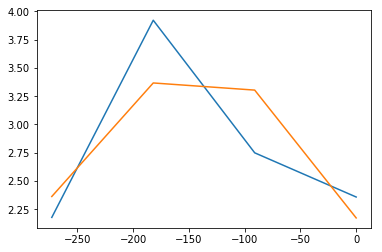

In [34]:

p = np.polyfit(x[:4], y[:4], 2)
yfit = np.polyval(p, x)
sigma = (y[:4] - yfit[:4]) / y[:4]
error = sigma * sigma
res = error.sum()
plt.plot(x,y)
plt.plot(x,yfit)
plt.show()

In [35]:
print(p)
print(error)
print(res)
print((sales[4] - sales[3])/(days[4] - days[3]))
print((eps[4] - eps[3])/(days[4] - days[3]))
print((y[2] - y[0])/(x[2] - x[0]))

[ -6.43038280e-05  -1.82472527e-02   2.17550000e+00]
[ 0.00611179  0.04051071  0.01993715  0.00716275]
0.0737224063131
78802197.8022
0.00549450549451
-0.00857142857143


In [21]:
import datetime as dt
(dt.datetime(2016,12, 31) - dt.datetime(2018,6, 30)).days

-546

In [32]:
9.35-1.68- 2.11- 3.38

2.1800000000000006

In [13]:
229234 - 45408- 52896- 78351

52579

## Candidate keywords  
### Shareholder's equity  
*  FinancialSupportCapitalContributionsMember
*  StatementOfStockholdersEquityAbstract
*  StockholdersEquity
### EPS/Earnings/Profits/Income  
*  EarningsPerShareBasic
*  EarningsPerShareDiluted
*  IncomeLossFromContinuingOperationsPerDilutedShare(?)
*  IncomeLossFromContinuingOperationsPerBasicShare (?)
### Sales/Net sales/net revenue  
*  SalesRevenueNetMember (?)
*  Search for 'Revenue' in income statement (?)
### Others that might be of interest  
*  us-gaap:StockRepurchasedDuringPeriodShares


# Data to extract from filing:
*  Earnings for current Q
*  Earnings for last 12-20 Q
*  Sales
*  Annual EPS for last 4 years
*  ROE (= net income / shareholder's equity)
# Parameters to calculate for each company:
*  Earnings increase: earning for current Q/earnings for same Q prior year
*  Excellency of earnings increase: each of two most recent Q/same Q's prior year + growth rate over last three years
*  Earnings growth acceleration in last 10 Q (calculate 2nd derivative?)
   *  two consecutive Qs of earnings *deceleration* could mean trouble
   *  plot earnings on log-scale for last 12 months to see acceleration
*  Sales increase: 
   *  current Q/prior Q > 25%
   *  *or* Sales growth is accelerating in the last three Q
*  Acceleration of sales growth and earnings growth in last three Q (don't sell if accelerating!)
*  Annual EPS should be increasing in each of the last three years.
*  ROE>17%
*  Stability of Q-EPS over last 3-5 years (plot EPS, fit line through data to determine growth trend, calculate deviation of EPS's from this growth trend (i.e. goodness of fit))

In [ ]:
import requests
from bs4 import BeautifulSoup as Bsoup
import pandas as pd

In [ ]:
ticker = "NVDA"
## Read in the file
f = open ("1045810_NVIDIA-CORP_10-Q_2017-08-23", "r")
lines = f.readlines ()
f.close ()
ser = pd.Series (lines)
#print (ser)
#this denotes where the actual 10-Q starts. I think the 10-Q part is enclosed by <document> tags
html_idxs = (ser[ser == '<TYPE>10-Q\n'])
#get the line number (== index number):
print ("html_idxs: {}".format(html_idxs.index.values))
#and the corresponding line
print (lines[html_idxs.index.values[0]])
#html_idxs_end = (ser['<\TYPE>' in ser])
#print ("html_idxs_end: {}".format (html_idxs_end.index.values))
#print (lines[html_idxs_end.index.values[0]])

#now I can parse the 10-Q with beautifulsoup:
## Find a way to determine which lines to parse automatically. Really, I only need the html-tag, i.e. lines 55-63 
## (see NVDA_finstat_test.hmtl)
soup = Bsoup ("".join (lines[55:63]), "lxml") #find the end of the section by searching for /Document?
#collect all div-tags for future use
all_divs = soup.find_all ("div")
#find the div-tag that contains 'ITEM 1.&#160;&#160;FINANCIAL STATEMENTS' which indicates the start of the
#income statement's table
#will this work on all filings???

print ("found {} occurrences". format (len(all_divs)))
tables = soup.find_all ("table")
print ("found {} tables".format (len(tables)))
#iterate over the div-tags, not sure if there is a better way. I think everything is is div tags.
flag = False
count = 0
for f in all_divs:
    #find beginning of financial statements
    if (f.get_text().startswith ("ITEM 1.") and "FINANCIAL STATEMENTS" in f.get_text()):
        flag = True
        #print (count)
    if (flag):
        #print (f.get_text())
        if ("three months ended" in f.text.lower()):
            ## At this point, we found the div-tag with the income-statement table
            ## Try to use pandas
            #print((f.find_all('div', text='$')))
            for ff in f.find_all('div',text='$'):
                ff.decompose()
            ## Almost! Just need to get rid of the '$', which are offsetting the affected rows by several columns
            ## This removes the '$' (use re.compile for other currency symbols?), now what about the paren's denoting negative numbers?
            tableDf=pd.read_html(str(f))
            print(tableDf)
            ## Manual method
            trs = f.find_all("tr")
            #print (len(trs))
            #print(trs[2].get_text())
            for t in trs:
                tlist = [item.get_text() for item in t.find_all("td")]
                print(" || ".join(tlist))
            #print (trs)
            break
        #print ("\n")
    count += 1



### See these urls for downloading the appropriate files, and parsing XBRL with Python/BeautifulSoup
*  https://www.codeproject.com/Articles/1227765/Parsing-XBRL-with-Python
*  https://www.slideshare.net/afalk42/xbrl-us-altova-webinar
### Taxonomy:
*  http://www.xbrlsite.com/LinkedData/BrowseObjectsByType_HTML.aspx?Type=%5BConcept%5D&Submit=Submit
*  ~~I think I want the instance xml file for each filing,~~ though that \*.txt file I've been downloading so far contains *everything* (I think). Could use that as well, the benefits are that the name of this file is standardized and I already have the machinery to download it in place, but the trade-off is that it's the biggest file for each filing. 
   *  The instance document can be found in the \*.txt file; it has the `<description>` XBRL INSTANCE DOCUMENT. Inside the description-tag is the `<XBRL>`, which contains the XBRL-data for the instance document. Note that there are several XBRL- tags containing the various XBRL documents (schema, extension, linkbases, ...).  
*  Search for the tags 'us-gaap:\*', they contain the items for the financial statements.
*  Also, Wikipedia has a good reference on the components of XBRL: 
   *  https://en.wikipedia.org/wiki/XBRL
### To do:
-  Figure out which taxonomy items I want/need, and all their permutations
-  Determine the date on each item
   -  Each us-gaap:\* - tag has a context-ref (e.g. "FI2017Q4"). Find the corresponding context (in the instance document, below the us-gaap - tags):
      ```
      <xbrli:context id="FI2017Q4">
		<xbrli:entity>
			<xbrli:identifier scheme="http://www.sec.gov/CIK">0001045810</xbrli:identifier>
		</xbrli:entity>
		<xbrli:period>
			<xbrli:instant>2017-01-29</xbrli:instant>
		</xbrli:period>
	</xbrli:context>
    ```  
### Interesting classifiers:
-  unitref=
